# Muhold keringesenek vizsgalata kozegellenallassal

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# fontos allandok definialasa
gamma = 6.67e-11
M_Fold = 5.972e24
R_Fold = 6378000.0

nap = 60 * 60 * 24 # nap secondum-ban, 1 nap 24 h -> 1 ora 60 m -> 1 perc 60 s
ev = 365.242195 * nap # ev secondum-ban

rho0 = 1.2 # rho0 erteke
h0 = 10400.0 # h0 erteke
m = 83.6 # test tomege
C = 0.47 # alak legellenallas tenyezoje 
A = (0.58/2)**2 * np.pi # gomb keresztmetszet felulete


In [3]:
# egyszeru mozgas egyenlet megoldo
# xn: hely-ido, vn: seb-ido, m: tomeg, F: erofuggveny, dt: idopillanat
def lepes ( xn, vn, m, F, dt):
    a = F ( xn, vn, m ) / m
    v_new = dt * a + vn
    # print( (v_new**2).sum()**0.5 )
    x_new = dt * v_new + xn
    # print( (x_new**2).sum()**0.5 - R_Fold )
    return ( x_new, v_new )

In [4]:
# Erofuggveny xyz koordinatakkal (3D ben)

def rho( h ):
    # print ( h )
    return ( rho0 * np.exp( -h / h0 ) )

def F_kozeg( c, a, rho, v): # kozegellenallas nagy sebessegnel
    v_abs = ( v**2 ).sum()**0.5
    # print(rho)
    f_kozeg = ( -(1/2) * c * a * rho * v * v_abs )
    # print( f_kozeg )
    return ( f_kozeg )
    
M = M_Fold # a gravitacios erofuggvenyt hasznaljuk, ehhez a fold tomege kell nekunk

def F_grav( r, v, m ): # r: origotol vett tavolsag
    r_abs = ( r**2 ).sum()**0.5 # r hossza / nagysaga
    f_grav = -gamma * M * m * r / r_abs**3
    return ( f_grav )


def F_grav_kozeg(r, v, m): # grav kozegellenallassal
    f_grav = F_grav(r, v, m)
    h = (r**2).sum()**0.5 - R_Fold
    rhoVar = rho( h )
    # print ( "h erteke: %f m, rho erteke: %e"%(h, rhoVar) )
    f_kozeg = F_kozeg( C, A, rhoVar, v)
    f_grav_kozeg = f_grav + f_kozeg
    # print ("Gravitacio: x = %.2f y = %.2f z = %.2f\tKozegellenallas: x = %.6f y = %.2f z = %.6f"%(f_grav[0], f_grav[2], f_grav[1], f_kozeg[0], f_kozeg[2], f_kozeg[1]) )
    return ( f_grav_kozeg )

### Becsapodas vizsgalat

In [5]:
h_start = 200.0 * 1000.0 # kezdo magassag fold felszinetol szamitva
v_start = 8200.0 # kezdosebesseg

# r0 es v0 vectorkent, koordinatak felosztasa -> x z y 
# (y erteke mindig 0 lesz mert csak x es z iranyba mozgatjuk a muholdat)
r0 = np.array([R_Fold+h_start, 0.0, 0.0], np.float64) # kezdo hely
v0 = np.array([0.0, v_start, 0.0], np.float64) # kezdo sebesseg

dt = 1.0 # idolepes

r = r0
v = v0

k_szog = 0.0

t = 0.0 # t0 ido 
t_max = 365.0 * nap

In [6]:
# numpy array-ek letrehozasa, t_list alapjan, x z y koodrinatakkal
t_list= np.arange(t, t_max, dt) # t_list letrehozasa t kezdo t_max veg dt lepeskoz alapjan
r_arr= np.zeros((t_list.shape[0], 3), dtype=np.float64)
v_arr= np.zeros((t_list.shape[0], 3), dtype=np.float64)

becsapodas=False
for i in range(len(t_list)): # r[2]>0: még nem esett le!
    r_abs=(r**2).sum()**0.5 # fold sugara es h magassag osszege
    k_szog = np.arccos(r[0]/r_abs) # arccos(rx(t)/r_abs) egy keringesen belul megtett ut radianban
    r_arr[i] = r
    v_arr[i] = v
    if r_abs<R_Fold:   # becsapódtunk
        becsapodas=True
        t_b_i = i
        break
    r, v = lepes(r, v, m, F_grav_kozeg, dt)
    
# tömbbé alakítjuk
# r_arr=np.asarray(r_list)
# v_arr=np.asarray(v_list)
# print (r_arr)

Text(0, 0.5, 'z')

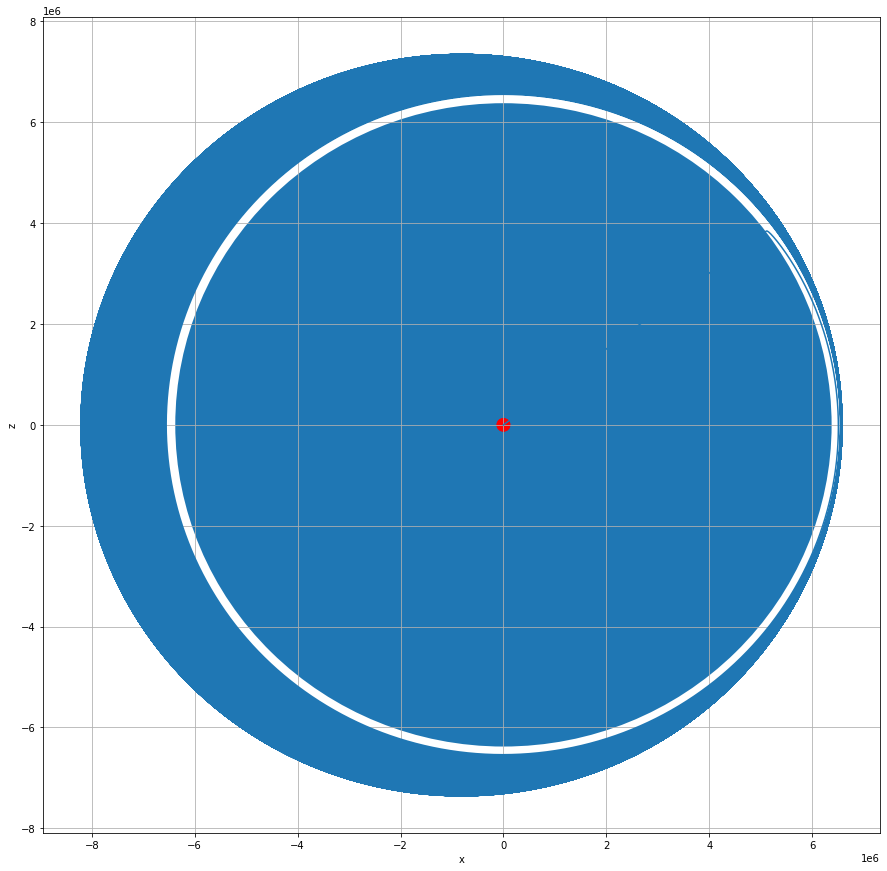

In [7]:
# kiplottoljuk az ertekeket
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(111)
ax1.plot(r_arr[:, 0], r_arr[:, 1])

circ = plt.Circle((0,0), R_Fold)
kp = plt.Circle((0,0), R_Fold/50.0, color="red")
ax1.add_patch(circ)
ax1.add_patch(kp)
ax1.grid()
ax1.set_xlabel('x')
ax1.set_ylabel('z')

In [44]:
if becsapodas:
    print("A műhold a vizsgált időszakban becsapódott a felszínbe!")
    print("t=%.02f s"%t_list[t_b_i])
    print("%.02f nap"%(t_list[t_b_i]/nap))
    print("v=%.02f m/s"%((v_arr[t_b_i,:]**2).sum()**0.5))
    z_loc_max = np.zeros((r_arr.shape[0]), dtype=bool) # array generalas z koord max helyeinek
    z_loc_max[1:-1] = (r_arr[1:-1, 1] > r_arr[0:-2, 1]) & (r_arr[1:-1, 1] > r_arr[2:, 1]) # ha elotte es utana levo kisebb akkor True egyebkent False
    print("%d keringés után csapódott be."%len(z_loc_max[z_loc_max == True])) # max helyek megszamolasa
else:
    print("A műhold a vizsgált időszakban nem csapódott be a felszínbe!")

A műhold a vizsgált időszakban becsapódott a felszínbe!
t=19335983.00 s
223.80 nap
v=107.46 m/s
3251 keringés után csapódott be.


Text(0, 0.5, 'v_xyz(t)')

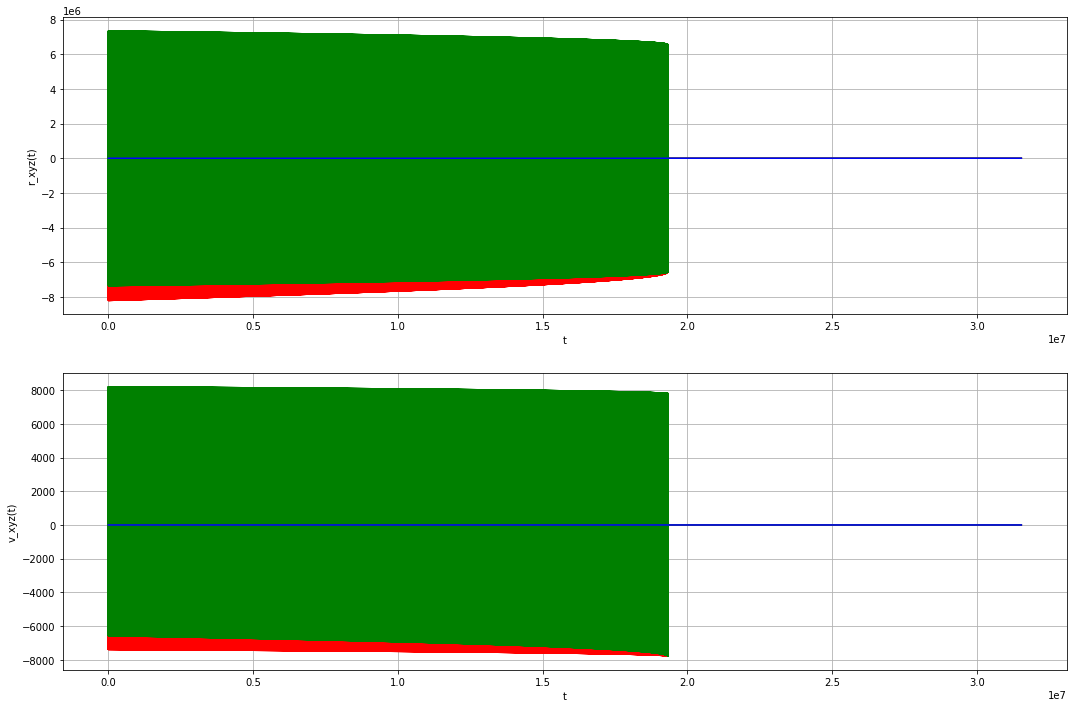

In [9]:
fig=plt.figure(figsize=(18,12))  
ax1=fig.add_subplot(211) # két rész-grafikon
ax2=fig.add_subplot(212)
ax1.plot(t_list, r_arr[:,0], color="red") # rx(t)
ax1.plot(t_list, r_arr[:,1], color="green") # rz(t)
ax1.plot(t_list, r_arr[:,2], color="blue") # ry(t)
ax2.plot(t_list, v_arr[:,0], color="red") # vx(t)
ax2.plot(t_list, v_arr[:,1], color="green") # vz(t)
ax2.plot(t_list, v_arr[:,2], color="blue") # vy(t)
ax1.grid()
ax2.grid()
ax1.set_xlabel("t")
ax1.set_ylabel("r_xyz(t)")
ax2.set_xlabel("t")
ax2.set_ylabel("v_xyz(t)")